## **0. Récupération du fichier de travail**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
# Import des packages pour la visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme() # pour modifier le thème
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
import scipy.stats as stats
from scipy.stats import anderson


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/ML_C02_reg.csv', index_col = 0)
# Le document ML_02_reg.csv est le DataFrame obtenu après nettoyage et analyse du DataFrame initial df_2013.csv
# C'est à partir de ces données que nous effectuerons la regression multiple

In [ ]:
df.head()

,Marque,cat,mq,genre,Carburant,gamme2,Hybride,Puissance maximale (kW),Consommation urbaine (l/100km),CO2,HC+NOX (g/km),masse vide euro min (kg),Carrosserie,cat_poll,boite,rapport,norme EURO
0,ALFA-ROMEO,M10,ALF,VP,ES,MOY-SUPERIEURE,non,147.0,11.3,182.0,0.225175,1505,BREAK,E,M,6,EURO5
1,ALFA-ROMEO,M10,ALF,VP,GO,MOY-SUPERIEURE,non,125.0,6.6,136.0,0.190000,1565,BERLINE,C,M,6,EURO5
2,ALFA-ROMEO,M10,ALF,VP,GO,MOY-SUPERIEURE,non,100.0,6.6,134.0,0.175000,1565,BERLINE,C,M,6,EURO5
3,ALFA-ROMEO,M10,ALF,VP,GO,MOY-SUPERIEURE,non,100.0,6.6,134.0,0.175000,1565,BERLINE,C,M,6,EURO5
4,ALFA-ROMEO,M10,ALF,VP,GO,MOY-SUPERIEURE,non,125.0,6.9,139.0,0.193000,1565,BERLINE,C,M,6,EURO5


In [ ]:
# Notre variable cible ici sera "CO2"
# On élimine la variable "cat_poll"
df = df.drop('cat_poll', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44231 entries, 0 to 44849
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Marque                          44231 non-null  object 
 1   cat                             44231 non-null  object 
 2   mq                              44231 non-null  object 
 3   genre                           44231 non-null  object 
 4   Carburant                       44231 non-null  object 
 5   gamme2                          44231 non-null  object 
 6   Hybride                         44231 non-null  object 
 7   Puissance maximale (kW)         44231 non-null  float64
 8   Consommation urbaine (l/100km)  44231 non-null  float64
 9   CO2                             44231 non-null  float64
 10  HC+NOX (g/km)                   44231 non-null  float64
 11  masse vide euro min (kg)        44231 non-null  int64  
 12  Carrosserie                     

In [ ]:
df.describe()

,Puissance maximale (kW),Consommation urbaine (l/100km),CO2,HC+NOX (g/km),masse vide euro min (kg),rapport
count,44231.000000,44231.000000,44231.000000,44231.000000,44231.000000,44231.000000
mean,125.231815,9.688409,199.176256,0.225175,2076.426353,5.848229
std,49.242734,2.339535,38.805952,0.036089,335.292306,0.839077
min,10.000000,0.000000,0.000000,0.038000,825.000000,0.000000
25%,100.000000,8.800000,189.000000,0.216000,1976.000000,5.000000
50%,120.000000,9.800000,203.000000,0.225175,2076.000000,6.000000
75%,125.000000,10.700000,221.000000,0.248000,2255.000000,6.000000
max,559.300000,41.100000,572.000000,0.306000,3115.000000,8.000000


## **1. Définition d'une fonction de validation de régression**

In [ ]:
def validation_lr(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    # Analyse des résidus:
    pred_train = lr.predict(X_train)
    residus = pred_train - y_train
    print("R2 modèle_train =", lr.score(X_train, y_train))
    print("R2 obtenu par CV =", cross_val_score(lr,X_train,y_train).mean())
    print("R2 modèle_test =",lr.score(X_test, y_test))
    print('RMSE train =', np.sqrt(mean_squared_error(y_train, pred_train)))
    print('RMSE test =', np.sqrt(mean_squared_error(pred_test, y_test)))
    # Graphes :
    plt.figure(figsize = (15,7))
    # Graphe prédictions en fonction de y_test (= le long de la droite si elles sont bonnes):
    plt.subplot(2,2,1)
    plt.scatter(pred_test, y_test)
    plt.title('pred_test en fonction de y_test')
    plt.xlabel('y_test')
    plt.ylabel('pred_test')
    plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), lw = 3, color ='red')
    # Graphe résidus en fonction de y_train:
    plt.subplot(2,2,2)
    plt.scatter(y_train, residus)
    plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='red')
    plt.title('Résidus en fonction de y_train')
    plt.xlabel('CO2 (g/km)')
    plt.ylabel('Résidus')
    # Graphe normalisation résidus:
    plt.subplot(2,2,3)
    residus_norm = (residus-residus.mean())/residus.std()
    stats.probplot(residus_norm, plot = plt);
    result = (anderson(residus_norm, dist='norm'))
    print(f"A-D statistic: {result[0]}")
    print(f"Critical values: {result[1]}")
    print(f"Significance levels: {result[2]}")


## **2. RL multiple sur variables numériques uniquement**

In [ ]:
# Séparartion variables explicatives de la cible:
target = df.select_dtypes(exclude = 'object').CO2
feats_num = df.select_dtypes(exclude = 'object').drop(['CO2'], axis = 1)

# Séparartion des jeux d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(feats_num, target, test_size = 0.2, random_state = 4)

# Normalisation des données sur X_train:
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train)

## Application de la transformation à X_train_n et X_test_n:
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)

feats_num.columns


Index(['Puissance maximale (kW)', 'Consommation urbaine (l/100km)',
       'HC+NOX (g/km)', 'masse vide euro min (kg)', 'rapport'],
      dtype='object')

R2 modèle_train = 0.9515849836263525
R2 obtenu par CV = 0.9515067274964526
R2 modèle_test = 0.9498972649928586
RMSE train = 8.556468140973184
RMSE test = 8.612489665710783
A-D statistic: 446.42304293474444
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


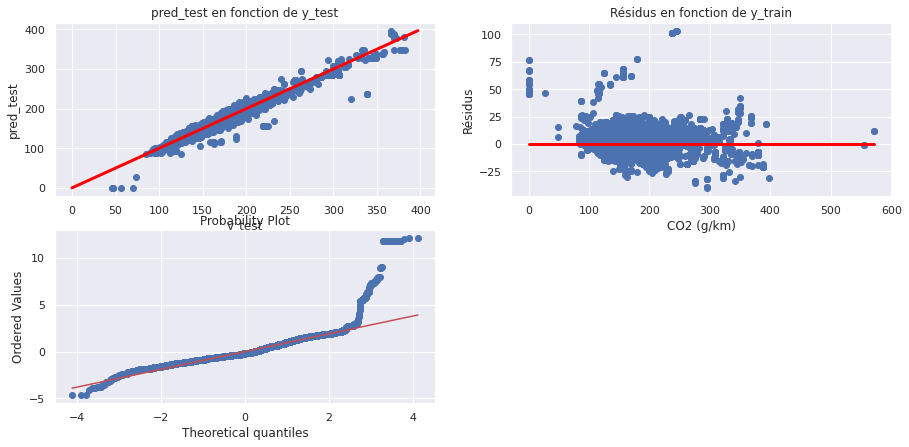

In [ ]:
# RL:
validation_lr(X_train_n, X_test_n, y_train, y_test)

In [ ]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Création d'un sélecteur à partir de lr:
sfm = SelectFromModel(lr)

# Sauvegarde des colonnes de X_train sélectionnées par sfm:
sfm_train = sfm.fit_transform(X_train_n, y_train)

# Sauvegarde des colonnes de X_test
sfm_test = sfm.transform(X_test_n)

# Affichage des variables sélectionnées:
X_train.columns[sfm.get_support()]

Index(['Consommation urbaine (l/100km)', 'masse vide euro min (kg)'], dtype='object')

R2 modèle_train = 0.9386070295747466
R2 obtenu par CV = 0.9385597955262188
R2 modèle_test = 0.9372622169363628
RMSE train = 9.635268457651689
RMSE test = 9.63745983265357
A-D statistic: 332.34898128007626
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


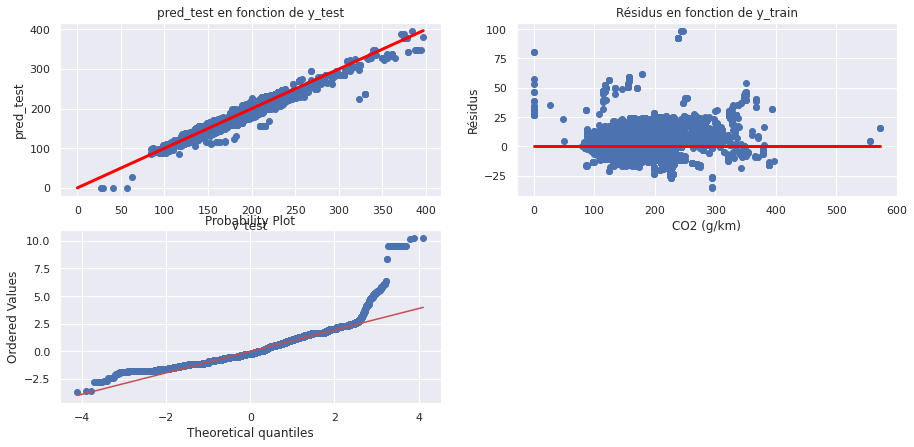

In [ ]:
# Validation modèle:
validation_lr(sfm_train, sfm_test, y_train, y_test)


## **3. RL multiple avec variables numériques et catégorielles**

In [ ]:
# On sépare les variables numériques et catégorielles
var_num = df.select_dtypes(exclude = 'object') # On récupère les variables numériques
var_cat = df.select_dtypes(include = 'object') # On récupère les variables catégorielles

In [ ]:
# Les variables catégorielles sont transformées en indicatrices
var_cat_ind = pd.get_dummies(var_cat)
var_cat_ind

,Marque_ALFA-ROMEO,Marque_ASTON MARTIN,Marque_AUDI,Marque_BENTLEY,Marque_BMW,Marque_CADILLAC,Marque_CHEVROLET,Marque_CITROEN,Marque_DACIA,Marque_DANGEL,...,Carrosserie_TS TERRAINS/CHEMINS,boite_A,boite_Autres,boite_M,norme EURO_12EUR,norme EURO_1EURO,norme EURO_2EURO,norme EURO_74EEV,norme EURO_EURO5,norme EURO_EURO6
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44845,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
44846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
44847,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
44848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
df_complet = var_num.join(var_cat_ind)
df_complet

,Puissance maximale (kW),Consommation urbaine (l/100km),CO2,HC+NOX (g/km),masse vide euro min (kg),rapport,Marque_ALFA-ROMEO,Marque_ASTON MARTIN,Marque_AUDI,Marque_BENTLEY,...,Carrosserie_TS TERRAINS/CHEMINS,boite_A,boite_Autres,boite_M,norme EURO_12EUR,norme EURO_1EURO,norme EURO_2EURO,norme EURO_74EEV,norme EURO_EURO5,norme EURO_EURO6
0,147.0,11.3,182.0,0.225175,1505,6,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,125.0,6.6,136.0,0.190000,1565,6,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,100.0,6.6,134.0,0.175000,1565,6,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,100.0,6.6,134.0,0.175000,1565,6,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,125.0,6.9,139.0,0.193000,1565,6,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44845,120.0,8.6,169.0,0.152000,1799,6,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
44846,120.0,6.1,139.0,0.144000,1786,6,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
44847,120.0,7.7,154.0,0.132000,1726,6,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
44848,120.0,6.8,139.0,0.152000,1706,6,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
# On sépare les variables explicatives feats et la variable cible target
feats = df_complet.drop(['CO2'], axis = 1)
target = df_complet['CO2']

In [ ]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2, random_state = 3)

R2 modèle_train = 0.987052949220224
R2 obtenu par CV = 0.9867152351911411
R2 modèle_test = 0.9851076955129614
RMSE train = 4.410296845676719
RMSE test = 4.757770444097516
A-D statistic: 721.8838900058254
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


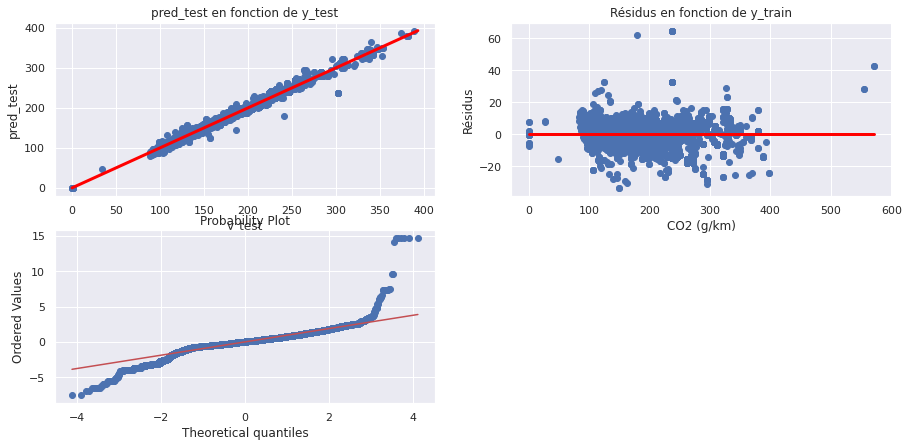

In [ ]:
# Validation du modèle:
validation_lr(X_train, X_test, y_train, y_test)

## **4. RL multiple avec normalisation et sélection de variables (SelectFromModel)**

##### **1. Préparation des données:**
###### Transformation des variables catégorielles en variables indicatrices
###### Normalisation des variables numériques sur X_train uniquement (pas sur variables catégorielles ni target)




In [ ]:
# Définition de la cible et varaibles explicatrices:
feats = df.drop('CO2', axis = 1)
target = df.CO2

# Transformation des variables catégorielles en variables indicatrices:
feats2 = pd.get_dummies(feats)

In [ ]:
# Séparation du jeu de données en un jeu d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(feats2, target, test_size = 0.2)

In [ ]:
# Normalisation des données numériques:
## Détection des variables numériques:
num_feats_train = feats.dtypes[feats.dtypes!= 'object'].index
## Ajustement du StandardScaler aux données numériques d'entrainement:
scaler = preprocessing.StandardScaler().fit(X_train[num_feats_train])

## Application de la transformation à X_train et X_test:
X_train[num_feats_train] = scaler.transform(X_train[num_feats_train])
X_test[num_feats_train] = scaler.transform(X_test[num_feats_train])

##### **2. Modéle RL + Sélecteur:**
###### SelectFromModel
###### Validation du modèle


In [ ]:
# Instanciation d'un modèle de régression linéaire
lr = LinearRegression()

# Création d'un sélecteur à partir de lr:
sfm = SelectFromModel(lr)

# Sauvegarde des colonnes de X_train sélectionnées par sfm:
sfm_train = sfm.fit_transform(X_train, y_train)

# Sauvegarde des colonnes de X_test
sfm_test = sfm.transform(X_test)

# Affichage des variables sélectionnées:
X_train.columns[sfm.get_support()]

Index(['Marque_ALFA-ROMEO', 'Marque_ASTON MARTIN', 'Marque_BMW',
       'Marque_CHEVROLET', 'Marque_VOLKSWAGEN', 'mq_ALF', 'mq_BMW', 'mq_SCF',
       'mq_VWG', 'Carburant_EL', 'Carburant_ES', 'Carburant_ES/GN',
       'Carburant_ES/GP', 'Carburant_FE', 'Carburant_GN', 'Carburant_GO',
       'gamme2_ECONOMIQUE', 'gamme2_INFERIEURE', 'gamme2_LUXE',
       'gamme2_MOY-INFERIEURE', 'gamme2_MOY-SUPERIEURE', 'gamme2_SUPERIEURE',
       'Hybride_oui', 'boite_A', 'boite_Autres', 'boite_M', 'norme EURO_12EUR',
       'norme EURO_1EURO', 'norme EURO_2EURO', 'norme EURO_74EEV',
       'norme EURO_EURO5', 'norme EURO_EURO6'],
      dtype='object')

R2 modèle_train = 0.47641392020161755
R2 obtenu par CV = -5.628669323067511e+20
R2 modèle_test = 0.4777396884081816
RMSE train = 28.05093929515821
RMSE test = 28.155554723591372
A-D statistic: 1447.1505666436206
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]


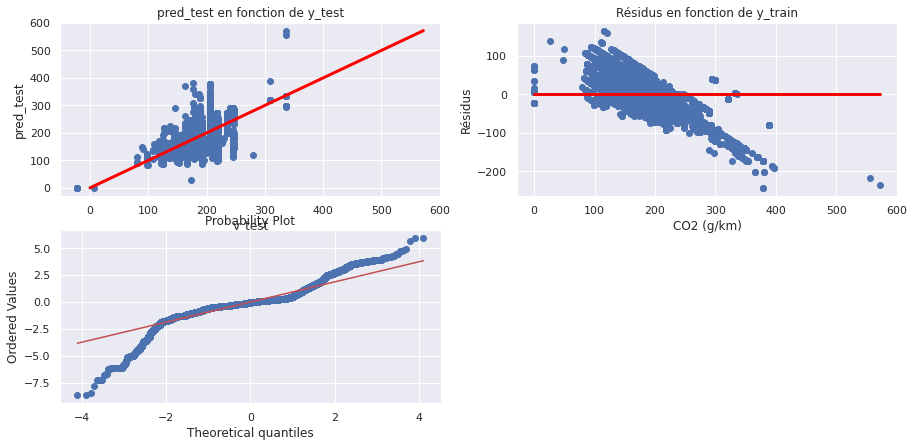

In [ ]:
# Validation du modèle:
validation_lr(sfm_train, sfm_test, y_train, y_test)

## **5. Lasso**

In [ ]:
# Utilisation de X_train et X_test issus de la normalisation précédente:
alpha_grid = {'alpha':[1/i for i in range(1,10)]}
lasso = Lasso()
crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
grid = GridSearchCV(estimator = lasso, param_grid = alpha_grid, cv=crossval)
grid.fit(X_train_n, y_train)
print(grid.best_params_)

{'alpha': 1.0}


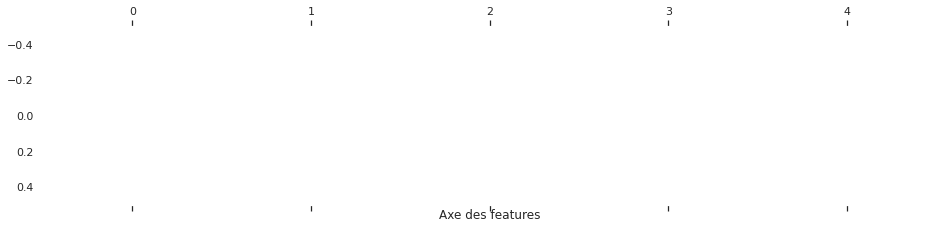

In [ ]:
best = grid.best_estimator_
sel = SelectFromModel(estimator = best, prefit = True,threshold = 1e-10)

mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

## **MACHINE LEARNING - Regression linéaire**
## Déterminer le niveau d'émission en CO2 du véhicule

## **Feature selction**

## **test Elastic Net?**